### (Demo) Connect 4

This document explains the implementation of a demo connect 4 environment, and players to play in
that environment.

#### Implemented algorithms

I have implemented for this project a few different algorithms for playing the game of connect 4. I
have chosen connect 4 because it is more complex than Tic-tac-toe while still being very simple to
implement. The following algorithms have been implemented:
* Simple _minimax_ (without using any sophisticated pruning)
* Simple _Monte Carlo tree search_ (using a uniformly random rollout policy)
* _AlphaZero_ (using a deep neural network trained for 200000 training steps)
* (Additionally, I implemented also a random player, and one which used the raw network trained by
AlphaZero without MCTS)

The players are implemented in a way as to use the complete time allowed by the time limit, and also
search the tree during the opponents turn. Some of them also reuse the search tree for subsequent
decision.

#### AlphaZero implementation

My implementation of the AlphaZero algorithm uses a very similar network to the one in the original
paper. I reduced the number of channels in the hidden layers from 256 to 32 and additionally reduced
the depth of the network from 19/39 residual blocks to only 10 residual blocks.

The self-play and training processes can be started using the commands from the root directory of this repository:
```
python -m azero.selfplay
python -m azero.train
```

The processes will use the file system to share the game history and network weights. Multiple
self-play processes can be started, but only one training process should be used. Each self-play
process will start multiple concurrent games, in order to allow for more efficient evaluation of the
network by queuing tasks and the evaluation multiple together. I let the network train for 200000
steps, making a checkpoint every 1000 steps. The following graphs show the training loss and Elo
ratings for different steps along the training process.

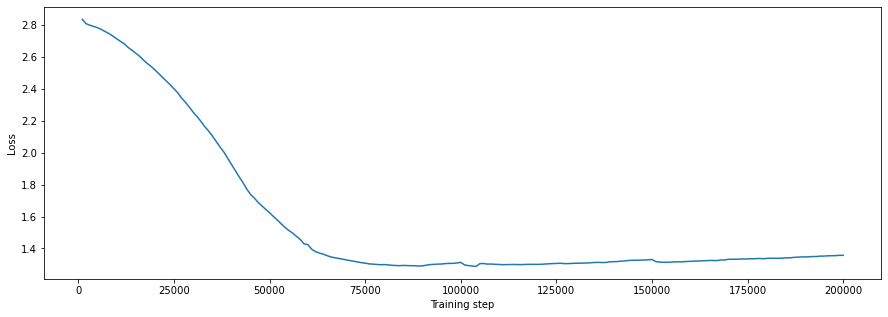

In [5]:
import json
import matplotlib.pyplot as plt

with open('data/loss.json') as file:
    loss = json.load(file)

data = [(int(s), l) for s, l in loss.items()]
step = [s for s, _ in data]
loss = [l for _, l in data]
plt.figure(figsize=(15, 5))
plt.xlabel('Training step')
plt.ylabel('Loss')
plt.plot(step, loss)
plt.show()

Note that since the target of the training is constantly evolving (since new data is added via
self-play), the loss is not a very useful metric to look at when evaluating the quality of the
training. Additionally, since part of the loss function is a cross entropy loss for the policy, the
loss will also reduce if the policy targets become more selective (i.e., less random).

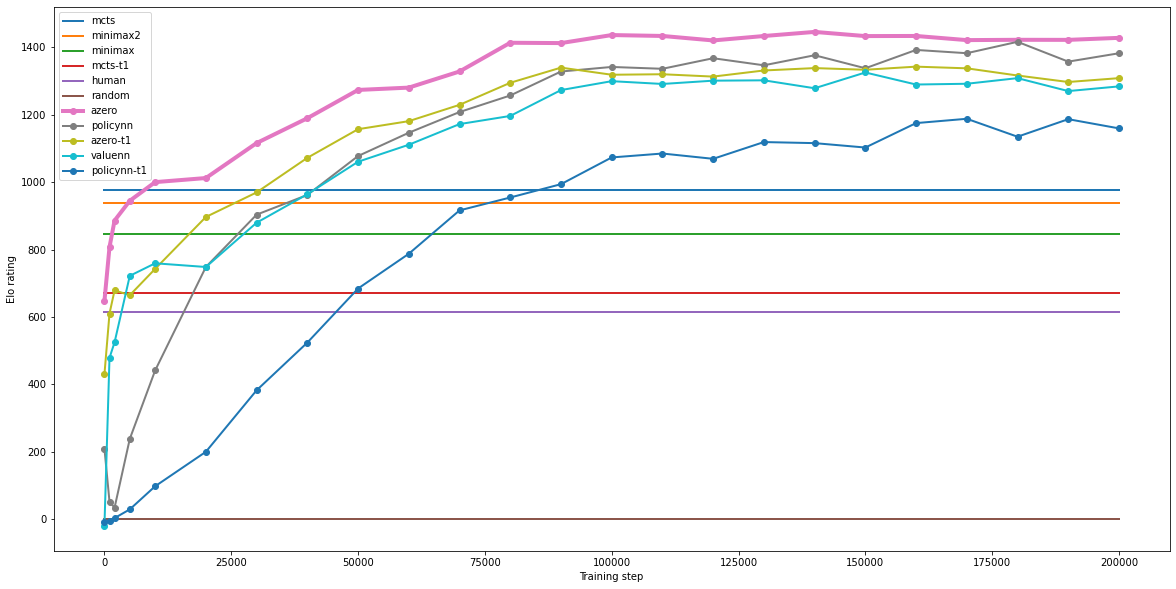

In [19]:
import re

with open('data/scores.json') as file:
    scores = json.load(file)

fixed = {}
steps = set()
trained = {}

for name, score in scores.items():
    match = re.match('(valuenn|policynn|azero)(\\d*)(-t1)?', name)
    if match:
        base = f'{match[1]}{match[3] or ""}'
        if base not in trained:
            trained[base] = []
        step = int(match[2])
        steps.add(step)
        trained[base].append((step, score))
    else:
        fixed[name] = score

steps = list(steps)

plt.figure(figsize=(20, 10))
plt.xlabel('Training step')
plt.ylabel('Elo rating')
for name, y in fixed.items():
    plt.plot(steps, [y] * len(steps), label=name, lw=2)
for name, data in trained.items():
    data.sort()
    x = [s for s, _ in data]
    y = [r for _, r in data]
    plt.plot(x, y, '-o', label=name, lw=2 if name != 'azero' else 4)
plt.legend()
plt.show()

#### Implemented scripts

I have also implemented some scripts for:
* `play.py` Playing against one of the AI players, or letting two AI players play against each other. The tool
allows for specified time limits decision (the human player is not bound by the time limits).
* `evaluate.py` Can be used to play a tournament between a set of different players. This is a
useful script for playing a lot of games and evaluating the relative performance of the algorithms.
Similar to the `play.py` script this scrip allows for defining a per action time limit. The script
has the additional capability of logging the game results to a file. It can also choose matches by
computing an approximate Elo rating for each player and matching players with similar scores.
* `score.py` This script can be used to calculate Elo ratings for each player from a set of game
logs generated by the `evaluate.py` script. For more information on how the scores are computed you
can have a look at [docs/EVAL.ipynb](docs/EVAL.ipynb).

#### Implemented widgets

The last thing implemented for this project is some code for playing games using `ipywdgets`. The
widget also shows some insights into the players, like value estimates, policy predictions, and
search tree size and depth. You can see the widget in the following cells.

You can select an algorithm for both player 1 and player 2. To play a single move you can use the
play button. If you enable the auto button, the agent will automatically play a move as soon as it
is his turn. Some extra information is printed for each player below the control ellements.

In [1]:
import sys
import os
sys.path.append(os.path.dirname(os.getcwd()))

from ipywidgets import widgets

from game.widget import WidgetGame, game_widget_for, player_widget_for

In [2]:
game = WidgetGame()
layout = widgets.Layout(
    display='flex',
    flex_flow='row',
    justify_content='space-around',
)
widgets.HBox(
    children=[
        player_widget_for(game, 0),
        game_widget_for(game),
        player_widget_for(game, 1)
    ],
    layout=layout
)